In [5]:
############################################################
### Project: Autoencoder with hidden layer constrained
############################################################

#### Prepare env
from __future__ import print_function
import h5py as h5
import numpy as np
import numba
import sklearn
import tensorflow as tf

print ("Numpy      ver. ", np.__version__)
print ("Numba      ver. ", numba.__version__)  ##  optimize numpy?!?
print ("H5Py       ver. ", h5.__version__)
print ("SKLearn    ver. ", sklearn.__version__)
print ("TensorFlow ver. ", tf.__version__)

import matplotlib
#matplotlib.use('agg')             ## Need for CMD
import matplotlib.pyplot as plt
%matplotlib inline

tf.reset_default_graph()

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())


Numpy      ver.  1.15.4
Numba      ver.  0.41.0
H5Py       ver.  2.7.1
SKLearn    ver.  0.19.2
TensorFlow ver.  1.12.0
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10503346741766320565
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 7588364685598657267
physical_device_desc: "device: XLA_GPU device"
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 14091881874487066601
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 134545408
locality {
  bus_id: 1
  links {
  }
}
incarnation: 9068322182177462645
physical_device_desc: "device: 0, name: GeForce GTX 1060 6GB, pci bus id: 0000:03:00.0, compute capability: 6.1"
, name: "/device:GPU:1"
device_type: "GPU"
memory_limit: 5769592832
locality {
  bus_id: 2
  numa_node: 1
  links {
  }
}
incarnation: 10631235674830832572
physical_device_des

In [6]:
#### Load waveform data

H5_FILE="white_h_8192_dm2.h5"
RATE=8192
H5_FILE="white_h_4096_dm2.h5"
RATE=4096

#!wget http://grqc.ncts.ncku.edu.tw/~lincy/GWDA/white_h_4096_dm2.h5
#!ls


# of whiten waveform for each set:  685


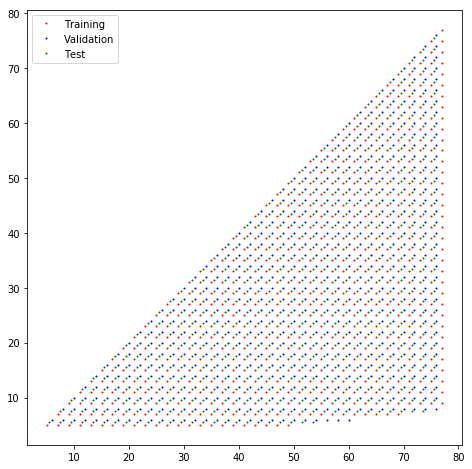

In [7]:
#### Now, visualize the dataset 

import h5py as h5
import matplotlib.pyplot as plt
%matplotlib inline

f = h5.File(H5_FILE,'r')
m1t = f['train_m1']
m2t = f['train_m2']
m1v = f['val_m1']
m2v = f['val_m2']
m1s = f['test_m1']
m2s = f['test_m2']

plt.figure(figsize=(8,8))
plt.plot(m2t, m1t, 'r.', markersize=2, label="Training")
plt.plot(m2v, m1v, 'b.', markersize=2, label="Validation")
plt.plot(m2s, m1s, 'g.', markersize=2, label="Test")
plt.axes().set_aspect('equal')
plt.legend()
#plt.show()
plt.savefig("VAE_tpl.png")

print ("# of whiten waveform for each set: ", len(f['train_hp']))

f.close()

In [8]:
###
###  Prepare data: extract, transform, load (ETL)
###
import time
#from datetime import datetime
from sklearn.model_selection import train_test_split


from sklearn.utils import shuffle

_NOISE_COPY_ = 1
class GWInject():
    def _add_noise(self, tag, A, nc):
        var = self.f[tag]
        NX = len(var)
        NN = nc * NX
        noise = np.random.normal(0,1,(NN,self.srate))    
        X     = np.random.normal(0,1,(NX,self.srate))  + A * var[:NX,:]      
        if self.plot:
            plt.figure(figsize=(18,6))
            for i in range(len(X)):
                plt.subplot(3,5,i+1)         
                plt.plot(X[i,:])
                plt.plot(A * var[i,:])
                #plt.title(" )
                if (i > 13): break
            plt.show()

        X = np.vstack( (noise, X )  ).astype(np.float32)
        Y = np.array([0]*NN + [1]*NX).astype(np.float32).reshape(-1,1)
        #return shuffle(X, Y, random_state=0)
        return X, Y
    
    def __init__(self, fname, plot=0):
        self.fname = fname
        self.plot = plot
        self.f = h5.File(fname, "r")
        self.srate = self.f.attrs.get('srate')   ##4096/ 8192
        print(self.srate, self.f.attrs.get('merger_idx'))
        
    def __exit__(self):
        self.f.close()
        
    def get_train_set(self, A=1.0, nc = _NOISE_COPY_):
        X, Y = self._add_noise('/train_hp', A, nc = nc)
        return X, Y
    def get_val_set(self, A=1.0, nc = _NOISE_COPY_):
        X, Y = self._add_noise('/val_hp', A, nc = nc)
        return X, Y
    def get_test_set(self, A=1.0):
        X, Y = self._add_noise('/test_hp', A, nc = _NOISE_COPY_)
        return X, Y

      
    def getdata(self, tag='/train', A=1.0):
        X1 = A*np.array(self.f[tag+'_hp'])  #.astype(np.float32)
        X2 = A*np.array(self.f[tag+'_hc'])  #.astype(np.float32)
        Y  = np.vstack(( self.f[tag+'_m1'],self.f[tag+'_m2'] )).astype(np.float32)
        
        if self.plot:
            plt.figure(figsize=(18,6))
            for i in range(len(X1)):
                plt.subplot(3,5,i+1)         
                plt.plot(X1[i,:])
                plt.title("m=(%.1f, %.1f)"%(Y[0,i],Y[1,i]))
                plt.xticks([])
                if (i > 13): break
            plt.show()
            
        return X1,X2,np.transpose(Y)
        #return np.hstack((X1, X2)), Y
    
#tmp = GWInject(H5_FILE, plot=0)
AMP = 0.7
#X,Y,_ = tmp.getdata('/train', A=AMP)  
#print(X.shape)
#print(X.shape)
#tmp.__exit__()

In [7]:
### Main autoencoder:  See https://www.ycc.idv.tw/tensorflow-tutorial_4.html
import random

class Autoencoder(object):
    def __init__(self,n_features,learning_rate=0.5,n_hidden=[1024,512,256,2],alpha=0.0):

        assert n_hidden[-1]==2, "!!! Make sure n_hidden[-1]==2"
        self.n_features = n_features
        self.n_hidden = n_hidden

        self.weights = None
        self.biases = None

        self.graph = tf.Graph() # initialize new grap
        self.build(n_features,learning_rate,n_hidden,alpha) # building graph
        self.sess = tf.Session(graph=self.graph) # create session by the graph 
        
        #summary_writer.add_graph(self.graph)

            
    def build(self,n_features,learning_rate,n_hidden,alpha):
        with self.graph.as_default():
            ### Input
            self.train_features = tf.placeholder(tf.float32, shape=(None,n_features))
            self.train_targets  = tf.placeholder(tf.float32, shape=(None,n_hidden[-1]))   ### for "constraint" hidden
            self.latent         = tf.placeholder(tf.float32, shape=(None, n_hidden[-1]))

            ### Optimalization
            # build neurel network structure and get their predictions and loss
            self.y_, self.original_loss, _ = self.structure(
                                               X=self.train_features,
                                               Y=self.train_targets, n_hidden=n_hidden )

            # regularization loss
            # weight elimination L2 regularizer
            self.regularizer = tf.reduce_sum([tf.reduce_sum(
                        tf.pow(w,2)/(1+tf.pow(w,2))) for w in self.weights.values()]) \
                    / tf.reduce_sum(
                     [tf.size(w,out_type=tf.float32) for w in self.weights.values()])

            # total loss
            self.loss = self.original_loss + alpha * self.regularizer

            # define training operation
            self.optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
            self.train_op = self.optimizer.minimize(self.loss)

            ### Prediction
            self.new_features = tf.placeholder(tf.float32, shape=(None,n_features))
            self.new_targets  = tf.placeholder(tf.float32, shape=(None,n_hidden[-1]))
            self.new_y_, self.new_original_loss, self.new_encoder = self.structure(
                                                          X=self.new_features,
                                                          Y=self.new_targets, n_hidden=n_hidden)  
            self.new_loss = self.new_original_loss + alpha * self.regularizer

            ### genwf
            
            
            ### Initialization
            self.init_op = tf.global_variables_initializer()  

    def genwf(self, latent):
        activation = tf.math.atan
        decoder = self.getDenseLayer(self.latent,
                                     self.weights['decode1'],
                                     self.biases['decode1'],
                                     activation=activation)
        for i in range(1,len(self.n_hidden)):
            decoder = self.getDenseLayer(decoder,
                        self.weights['decode{}'.format(i+1)],
                        self.biases['decode{}'.format(i+1)],
                        activation=activation) 
        return self.sess.run(decoder, feed_dict={self.latent : latent})
      
    def generator(self, latent):
        activation = tf.math.atan
        decoder = self.getDenseLayer(latent,
                                     self.weights['decode1'],
                                     self.biases['decode1'],
                                     activation=activation)

        for i in range(1,len(self.n_hidden)):
            decoder = self.getDenseLayer(decoder,
                        self.weights['decode{}'.format(i+1)],
                        self.biases['decode{}'.format(i+1)],
                        activation=activation) 
        return decoder
      
    def structure(self, X, Y, n_hidden):
        ### Variable
        if (not self.weights) and (not self.biases):
            self.weights = {}
            self.biases  = {}

            n_encoder = [self.n_features] + n_hidden
            for i,n in enumerate(n_encoder[:-1]):
                #print ("e",i+1,n)
                self.weights['encode{}'.format(i+1)] = \
                    tf.Variable(tf.truncated_normal(
                        shape=(n,n_encoder[i+1]),stddev=0.1),dtype=tf.float32)
                self.biases['encode{}'.format(i+1)] = \
                    tf.Variable(tf.zeros( shape=(n_encoder[i+1]) ),dtype=tf.float32)

            #del list
            n_decoder = list(reversed(n_hidden))+[self.n_features]
            for i,n in enumerate(n_decoder[:-1]):
                #print ("d", i+1,n)
                self.weights['decode{}'.format(i+1)] = \
                    tf.Variable(tf.truncated_normal(
                        shape=(n,n_decoder[i+1]),stddev=0.1),dtype=tf.float32)
                self.biases['decode{}'.format(i+1)] = \
                    tf.Variable(tf.zeros( shape=(n_decoder[i+1]) ),dtype=tf.float32)                    

 
        activation = tf.math.atan
        encoder = self.getDenseLayer(X,
                                     self.weights['encode1'],
                                     self.biases['encode1'],
                                     activation=activation)
        for i in range(1, len(self.n_hidden)-1):
            encoder = self.getDenseLayer(encoder,
                        self.weights['encode{}'.format(i+1)],
                        self.biases['encode{}'.format(i+1)],
                        activation=activation)
        encoder = self.getDenseLayer(encoder,
                    self.weights['encode{}'.format(len(self.n_hidden))],
                    self.biases['encode{}'.format(len(self.n_hidden))],
                    activation=tf.nn.relu)

        decoder = self.generator(encoder)

        #loss = tf.nn.sigmoid_cross_entropy_with_logits(X, decoder)  +  tf.reduce_mean(tf.pow(Y- encoder, 2))
        loss = tf.reduce_mean( tf.nn.sigmoid_cross_entropy_with_logits(labels=X, logits=decoder) )
        #loss = tf.reduce_mean(tf.pow(X - decoder, 2))  +  tf.reduce_mean(tf.pow(Y- encoder, 2))

        return (decoder,loss,encoder)

    def getDenseLayer(self,input_layer,weight,bias,activation=None):
        x = tf.add(tf.matmul(input_layer,weight),bias)
        if activation:
            x = activation(x)
        return x


    def fit(self,X,Y,epochs=10,validation_data=None,test_data=None,batch_size=None):
        X = self._check_array(X)
        Y = self._check_array(Y)

        N = X.shape[0]
        random.seed(9000)
        if not batch_size: batch_size=N

        self.sess.run(self.init_op)
        start_time = time.time()
        for epoch in range(epochs):
            #if epoch%100==0:   print("Epoch %2d/%2d: "%(epoch+1,epochs))

            # mini-batch gradient descent
            index = [i for i in range(N)]   #random.shuffle(index)
            while len(index)>0:
                index_size = len(index)
                batch_index = [index.pop() for _ in range(min(batch_size,index_size))]
                merged = tf.summary.merge_all()

                feed_dict = {self.train_features: X[batch_index,:],
                             self.train_targets:  Y[batch_index,:]}
                _, loss = self.sess.run([self.train_op, self.loss], feed_dict=feed_dict)
                #_, loss, merged0 = self.sess.run([self.train_op, self.loss, merged], feed_dict=feed_dict)

                ##if epoch%100==0: print("[%d/%d] loss = %9.4f     " % ( N-len(index), N, loss ), end='\r')
                ##summary_writer.add_summary(merged0, epoch)

            # evaluate at the end of this epoch
            val_loss = 0
            if validation_data is not None: val_loss = self.evaluate(validation_data[0],validation_data[1])

            train_loss = self.evaluate(X,Y)
            if epoch%20==0: print("[%5d] %5ds tloss = %9.4f   vloss = %9.4f" % ( epoch, (time.time()-start_time), train_loss, val_loss ))

        if test_data is not None:
            test_loss = self.evaluate(test_data[0],test_data[1])
            print("test_loss = %9.4f" % (test_loss))

    #def encode(self,X):
    #    X = self._check_array(X)
    #    return self.sess.run(self.new_encoder, feed_dict={self.new_features: X})

    def predict(self,X):
        X = self._check_array(X)
        return self.sess.run(self.new_y_, feed_dict={self.new_features: X})

    def evaluate(self,X,Y):
        X = self._check_array(X)
        return self.sess.run(self.new_loss, feed_dict={self.new_features: X,
                                                       self.new_targets: Y})

    def _check_array(self,ndarray):
        ndarray = np.array(ndarray)
        if len(ndarray.shape)==1: ndarray = np.reshape(ndarray,(1,ndarray.shape[0]))
        return ndarray

In [8]:
### Training 

model_1 = Autoencoder( n_features = RATE,
                       learning_rate = 0.004,
                       #n_hidden=[4096, 2048, 512, 256, 128, 32, 16, 8, 2],
                       #n_hidden=[2048, 512, 256, 128, 2],  ### noise in inspiral region   0.001
                       n_hidden=[2048, 512, 256, 128, 2],
                       ##n_hidden=[2048, 1024, 512, 256, 128, 64], ## add 1024 will spoil the output###  64 latent OK   
                       alpha=0.001
                     )

tmp = GWInject(H5_FILE, plot=0)
Xt,Xt2,Yt = tmp.getdata('/train', A=AMP)  
Xv,Xv2,Yv = tmp.getdata('/val', A=AMP)  
Xs,Xs2,Ys = tmp.getdata('/test', A=AMP)  
#Xt=np.hstack((Xt1,Xt2))
#Xv=np.hstack((Xv1,Xv2))
#Xs=np.hstack((Xs1,Xs2))

model_1.fit(X=Xt, Y=Yt,
           epochs=3000,
           validation_data=(Xv, Yv),
           test_data=(Xs, Ys),
           batch_size = 128
          )




4096 0.66


ResourceExhaustedError: OOM when allocating tensor of shape [2,128] and type float
	 [[node Variable_10/Adam/Initializer/zeros (defined at <ipython-input-7-5b97dc3c177e>:46)  = Const[_class=["loc:@Variable_10/Assign"], dtype=DT_FLOAT, value=Tensor<type: float shape: [2,128] values: [0 0 0...]...>, _device="/job:localhost/replica:0/task:0/device:GPU:0"]()]]

Caused by op u'Variable_10/Adam/Initializer/zeros', defined at:
  File "/usr/lib64/python2.7/runpy.py", line 162, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/usr/lib64/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/usr/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/lib/python2.7/site-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/usr/lib64/python2.7/site-packages/tornado/ioloop.py", line 1065, in start
    handler_func(fd_obj, events)
  File "/usr/lib64/python2.7/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/lib64/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/usr/lib64/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/usr/lib64/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/usr/lib64/python2.7/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/usr/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/usr/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/usr/lib/python2.7/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/usr/lib/python2.7/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/usr/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2718, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/usr/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2822, in run_ast_nodes
    if self.run_code(code, result):
  File "/usr/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-8-f84f6b5a0749>", line 9, in <module>
    alpha=0.001
  File "<ipython-input-7-5b97dc3c177e>", line 15, in __init__
    self.build(n_features,learning_rate,n_hidden,alpha) # building graph
  File "<ipython-input-7-5b97dc3c177e>", line 46, in build
    self.train_op = self.optimizer.minimize(self.loss)
  File "/usr/lib/python2.7/site-packages/tensorflow/python/training/optimizer.py", line 410, in minimize
    name=name)
  File "/usr/lib/python2.7/site-packages/tensorflow/python/training/optimizer.py", line 593, in apply_gradients
    self._create_slots(var_list)
  File "/usr/lib/python2.7/site-packages/tensorflow/python/training/adam.py", line 135, in _create_slots
    self._zeros_slot(v, "m", self._name)
  File "/usr/lib/python2.7/site-packages/tensorflow/python/training/optimizer.py", line 1139, in _zeros_slot
    new_slot_variable = slot_creator.create_zeros_slot(var, op_name)
  File "/usr/lib/python2.7/site-packages/tensorflow/python/training/slot_creator.py", line 183, in create_zeros_slot
    colocate_with_primary=colocate_with_primary)
  File "/usr/lib/python2.7/site-packages/tensorflow/python/training/slot_creator.py", line 157, in create_slot_with_initializer
    dtype)
  File "/usr/lib/python2.7/site-packages/tensorflow/python/training/slot_creator.py", line 65, in _create_slot_var
    validate_shape=validate_shape)
  File "/usr/lib/python2.7/site-packages/tensorflow/python/ops/variable_scope.py", line 1487, in get_variable
    aggregation=aggregation)
  File "/usr/lib/python2.7/site-packages/tensorflow/python/ops/variable_scope.py", line 1237, in get_variable
    aggregation=aggregation)
  File "/usr/lib/python2.7/site-packages/tensorflow/python/ops/variable_scope.py", line 540, in get_variable
    aggregation=aggregation)
  File "/usr/lib/python2.7/site-packages/tensorflow/python/ops/variable_scope.py", line 492, in _true_getter
    aggregation=aggregation)
  File "/usr/lib/python2.7/site-packages/tensorflow/python/ops/variable_scope.py", line 922, in _get_single_variable
    aggregation=aggregation)
  File "/usr/lib/python2.7/site-packages/tensorflow/python/ops/variables.py", line 183, in __call__
    return cls._variable_v1_call(*args, **kwargs)
  File "/usr/lib/python2.7/site-packages/tensorflow/python/ops/variables.py", line 146, in _variable_v1_call
    aggregation=aggregation)
  File "/usr/lib/python2.7/site-packages/tensorflow/python/ops/variables.py", line 125, in <lambda>
    previous_getter = lambda **kwargs: default_variable_creator(None, **kwargs)
  File "/usr/lib/python2.7/site-packages/tensorflow/python/ops/variable_scope.py", line 2444, in default_variable_creator
    expected_shape=expected_shape, import_scope=import_scope)
  File "/usr/lib/python2.7/site-packages/tensorflow/python/ops/variables.py", line 187, in __call__
    return super(VariableMetaclass, cls).__call__(*args, **kwargs)
  File "/usr/lib/python2.7/site-packages/tensorflow/python/ops/variables.py", line 1329, in __init__
    constraint=constraint)
  File "/usr/lib/python2.7/site-packages/tensorflow/python/ops/variables.py", line 1437, in _init_from_args
    initial_value(), name="initial_value", dtype=dtype)
  File "/usr/lib/python2.7/site-packages/tensorflow/python/ops/variable_scope.py", line 896, in <lambda>
    shape.as_list(), dtype=dtype, partition_info=partition_info)
  File "/usr/lib/python2.7/site-packages/tensorflow/python/ops/init_ops.py", line 101, in __call__
    return array_ops.zeros(shape, dtype)
  File "/usr/lib/python2.7/site-packages/tensorflow/python/ops/array_ops.py", line 1551, in zeros
    output = _constant_if_small(zero, shape, dtype, name)
  File "/usr/lib/python2.7/site-packages/tensorflow/python/ops/array_ops.py", line 1509, in _constant_if_small
    return constant(value, shape=shape, dtype=dtype, name=name)
  File "/usr/lib/python2.7/site-packages/tensorflow/python/framework/constant_op.py", line 214, in constant
    name=name).outputs[0]
  File "/usr/lib/python2.7/site-packages/tensorflow/python/util/deprecation.py", line 488, in new_func
    return func(*args, **kwargs)
  File "/usr/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 3274, in create_op
    op_def=op_def)
  File "/usr/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 1770, in __init__
    self._traceback = tf_stack.extract_stack()

ResourceExhaustedError (see above for traceback): OOM when allocating tensor of shape [2,128] and type float
	 [[node Variable_10/Adam/Initializer/zeros (defined at <ipython-input-7-5b97dc3c177e>:46)  = Const[_class=["loc:@Variable_10/Assign"], dtype=DT_FLOAT, value=Tensor<type: float shape: [2,128] values: [0 0 0...]...>, _device="/job:localhost/replica:0/task:0/device:GPU:0"]()]]


In [ ]:
###
###  Test if it can produce an input GW signal
### 
for i in range(10,11):
    plt.figure()
    w0 = Xt[i]
    w1 = model_1.predict(w0)
    print (Yt[i,0],Yt[i,1])
    print (w1)
    print (w0.max(),w0.min())
    print (w1.max(),w1.min())
    plt.plot(w1[0])
    plt.plot(w0)
    #plt.show()
    plt.savefig("VAE_test1.png")

    plt.figure()    
    plt.plot(w1[0]-w0)
    plt.savefig("VAE_test1diff.png")
    #plt.show()

In [ ]:
###  Test if it can produce many input GW signals

plt.figure(figsize=(18,12))

ranidx = random.sample(range(len(Xt)), 30)   ## test randomly sample
w0 = Xt[ranidx]
w1 = model_1.predict(w0)

for i in range(len(ranidx)):
    plt.subplot(6,5,i+1)         
    plt.title("m=(%.1f, %.1f)"%(Yt[ranidx[i],0],Yt[ranidx[i],1]))
    plt.plot(w0[i]-w1[i])
    plt.xticks([])
    
    if (i > 25): break
plt.savefig("VAE_testdiff.png")

            
            
    

In [ ]:
###  Generate from latent variables

plt.figure(figsize=(18,12))

ranidx = random.sample(range(len(Xt)), 16)   ## test randomly sample
w0 = Xt[ranidx]
w1 = model_1.predict(w0)
wg = model_1.genwf(Yt[ranidx])
for i in range(len(ranidx)):
    plt.subplot(6,5,i+1)         
    plt.title("m=(%.1f, %.1f)"%(Yt[ranidx[i],0],Yt[ranidx[i],1]))
    plt.plot(wg[i])
    #plt.plot(w1[i]-wg[i])
    plt.xticks([])
    
    if (i > 25): break

#plt.show()
plt.savefig("VAE_gen.png")

 